In [ ]:
# Install FlyGym. This should take about 1 minute.
!pip install "flygym[examples]"

In [ ]:
# Set up GPU a few more and rendering parameters. This should take ~1 second.

from google.colab import files

import distutils.util
import os
import subprocess

if subprocess.run("nvidia-smi").returncode:
    raise RuntimeError(
        "Cannot communicate with GPU. "
        "Make sure you are using a GPU Colab runtime. "
        "Go to the Runtime menu and select Choose runtime type."
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
        f.write(
            """{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
        )

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print("Setting environment variable to use GPU rendering:")
%env MUJOCO_GL=egl

try:
    print("Checking that the installation succeeded:")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise e from RuntimeError(
        "Something went wrong during installation. Check the shell output above "
        "for more information.\n"
        "If using a hosted Colab runtime, make sure you enable GPU acceleration "
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print("Installation successful.")

In [ ]:
# clone the repo to colab to get the data
! git clone "https://github.com/NeLy-EPFL/neuromechfly-workshop.git"

# Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded an untethered fly walking in a narrow corrdior. We used the GUI of SLEAP to manually annotate ~50 frames of behavior recorded at 360 fps and downsampled to 130fps. When then leveraged the simple geometrical constraints of our setup to triangulate the 2d poses to a 3d poses. Used df3d post processing for alignement and interpolation and finally used Seqikpy to perform inverse kinematics. 

We are replaying this exact behavior:

<video width="" height="" controls>
  <source src="data/video_data/straight_walking_bout.mp4" type="video/mp4">
</video>

All the notebooks used to go from a raw video to joint angles can be found in this repo in the folder: 2d-3d

With these we will use a PD controller to actuate the DoFs of the simulated fly at using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

We start with the necessary imports:

In [21]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import Fly, Camera, SingleFlySimulation, get_data_path
from flygym.preprogrammed import all_leg_dofs, all_tarsi_links

from IPython.display import Video

# Load and format the raw data

In [22]:
def format_seqikpy_data(data, corresp_dict={"ThC": "Coxa",
                                             "CTr": "Femur",
                                               "FTi": "Tibia",
                                                 "TiTa": "Tarsus1"}
                                                 ):

    data_gym = {}
    for joint, values in data.items():
        if joint == "meta" or joint == "swing_stance_time":
            data_gym[joint] = values
        else:
            leg = joint[6:8]
            joint_name = joint[9:]
            seg, dof = joint_name.split("_")
            if dof == "pitch":
                newjoint = f"joint_{leg}{corresp_dict[seg]}"
            else:
                newjoint = f"joint_{leg}{corresp_dict[seg]}_{dof}"

            data_gym[newjoint] = values


    return data_gym

seq_ikpy_data_path = Path("data/inverse_kinematics/leg_joint_angles.pkl")
with open(seq_ikpy_data_path, "rb") as f:
    seq_ikdata = pickle.load(f)

data = format_seqikpy_data(seq_ikdata)

In [23]:
data["meta"].keys()

dict_keys(['timestep', 'source', 'status', 'interpolated', 'smoothed', 'window_size', 'conv_casting'])

# Set hyperparameters

In [24]:
timestep = 1e-4
actuated_joints = all_leg_dofs
run_time = len(data["joint_RFCoxa_yaw"])*data["meta"]["timestep"]

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

In [25]:
target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

print("Neuromechfly has {} actuated joints and the data contains {} interpolated steps adding up to a toal of {} seconds".format(*data_block.shape, run_time))

Neuromechfly has 42 actuated joints and the data contains 4390 interpolated steps adding up to a toal of 0.439 seconds


In [26]:
# The fly should walk more on the tippy toes
tarsus_offset = np.zeros(len(actuated_joints))
for i, joint in enumerate(actuated_joints):
    if "Tarsus" in joint:
        data_block[i, :] = -1*np.pi/5

In [27]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

fig.savefig(output_dir / "single_step.png")

In every leg 7 degrees of freedom are actuated adding up to 6*7 actuated joints. 

## Save time and joint angles to generate videos

In [10]:
np.save(output_dir / "joint_angles.npy", data_block)
np.save(output_dir / "actuated_joints.npy", np.array(actuated_joints))
np.save(output_dir / "output_t.npy", output_t)

# Determine swing and stance initiation 

In this example swing and stance initiation have been annotated manually from the video. For convinience, we compute when in seconds, the swing and the stance starts to accordingly actuate the adhesion. 

In [11]:
# legs = [side+pos for side in "LR" for pos in "FMH"]
# swing_stance_intervals = {}

# for leg in legs:
#     swing_stance_intervals[leg] = []
#     stance_starts = data["swing_stance_time"][leg]["stance"]
#     stance_ends = data["swing_stance_time"][leg]["swing"]

#     for start in stance_starts:
#         selected_end = None
#         for end in stance_ends:
#             if end > start:
#                 selected_end = end
#                 break
#         if selected_end is not None:
#             swing_stance_intervals[leg].append((start, selected_end))
#         else:
#             swing_stance_intervals[leg].append((start, run_time))

In [12]:
tarsal_joints = ["_".join(["joint", tarsus_seg]) for tarsus_seg in all_tarsi_links if not "Tarsus1" in tarsus_seg]
monitored_joints = actuated_joints + tarsal_joints
fly = Fly(init_pose="stretch", actuated_joints=actuated_joints, control="position", enable_adhesion=True, draw_adhesion=True, monitored_joints=monitored_joints, enable_vision=True, render_raw_vision=True)
play_speed = 0.05
cam = Camera(fly=fly, camera_id="Animat/camera_left", play_speed=play_speed, draw_contacts=True, play_speed_text=True)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()
obs_list = []
raw_vision_list = []

n_stabilization_steps = 1000
for i in trange(n_stabilization_steps):
    action = {"joints": data_block[:, 0], "adhesion": np.zeros(6)}
    obs, reward, terminated, truncated, info = sim.step(action)

#reset the current time to exclude the stabilization steps
sim.curr_time = 0
render_times = []


for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]
    adhesion = np.zeros(6)
    # for i, leg in enumerate(legs):
    #     for start, end in swing_stance_intervals[leg]:
    #         if start <= sim.curr_time  <= end:
    #             adhesion[i] = 1
    #             break
    action = {"joints": joint_pos, "adhesion": adhesion}
    obs, reward, terminated, truncated, info = sim.step(action)
    obs_list.append(obs)
    rend_flag = sim.render()[0]
    if not rend_flag is None:
        render_times.append(sim.curr_time)

    if fly.render_raw_vision:
        raw_vision_list.append(info["raw_vision"])

100%|██████████| 4390/4390 [00:17<00:00, 247.77it/s]


In [13]:
video_name = "kinematic_replay_{}.mp4".format(cam.camera_id.split("/")[1]) 
if cam.draw_contacts:
    video_name = video_name.replace(".mp4", "_contacts.mp4")

cam.save_video(output_dir / video_name, stabilization_time=0)
np.savetxt(output_dir / "render_times.txt", render_times)

# show the video
Video(output_dir/ video_name)

The first output of kinematic replay is a video that can be obtained from any different angles. Arrows at the leg tips represent the contact forces with the floor and the color of the tarsal segments encode the presence of absence of adhesion. Blue means adhesion is turned ON and adhering to the floor. Red means adhesion is ON but the leg is not in contact with the floor and finally if the tarsus is in the base color it means adhesion is OFF

# Leveraging kinematic replay

## Observation space

In [14]:
print(f"Observation list made {len(obs_list)} observations")
print("One observation contains information about:")
for key in obs_list[0].keys():
    try:
        print(key, obs[key].shape)
    except AttributeError:
        print(key)

Observation list made 4390 observations
One observation contains information about:
joints (3, 66)
fly (4, 3)
contact_forces (30, 3)
end_effectors (6, 3)
fly_orientation (3,)
cardinal_vectors (3, 3)
vision (2, 721, 2)


## Joint torques

Torque within joints would be impossible to monitor in a behaving fly. Being able to infer them from kinematic replay allows us to get an abstract sensory signal that could be extracted from the fly's sensory organs. With more modelling efforts one could directly implement sensory organs that would change their firing rate depending on the experienced torque.

### Torque in actively controlled joints

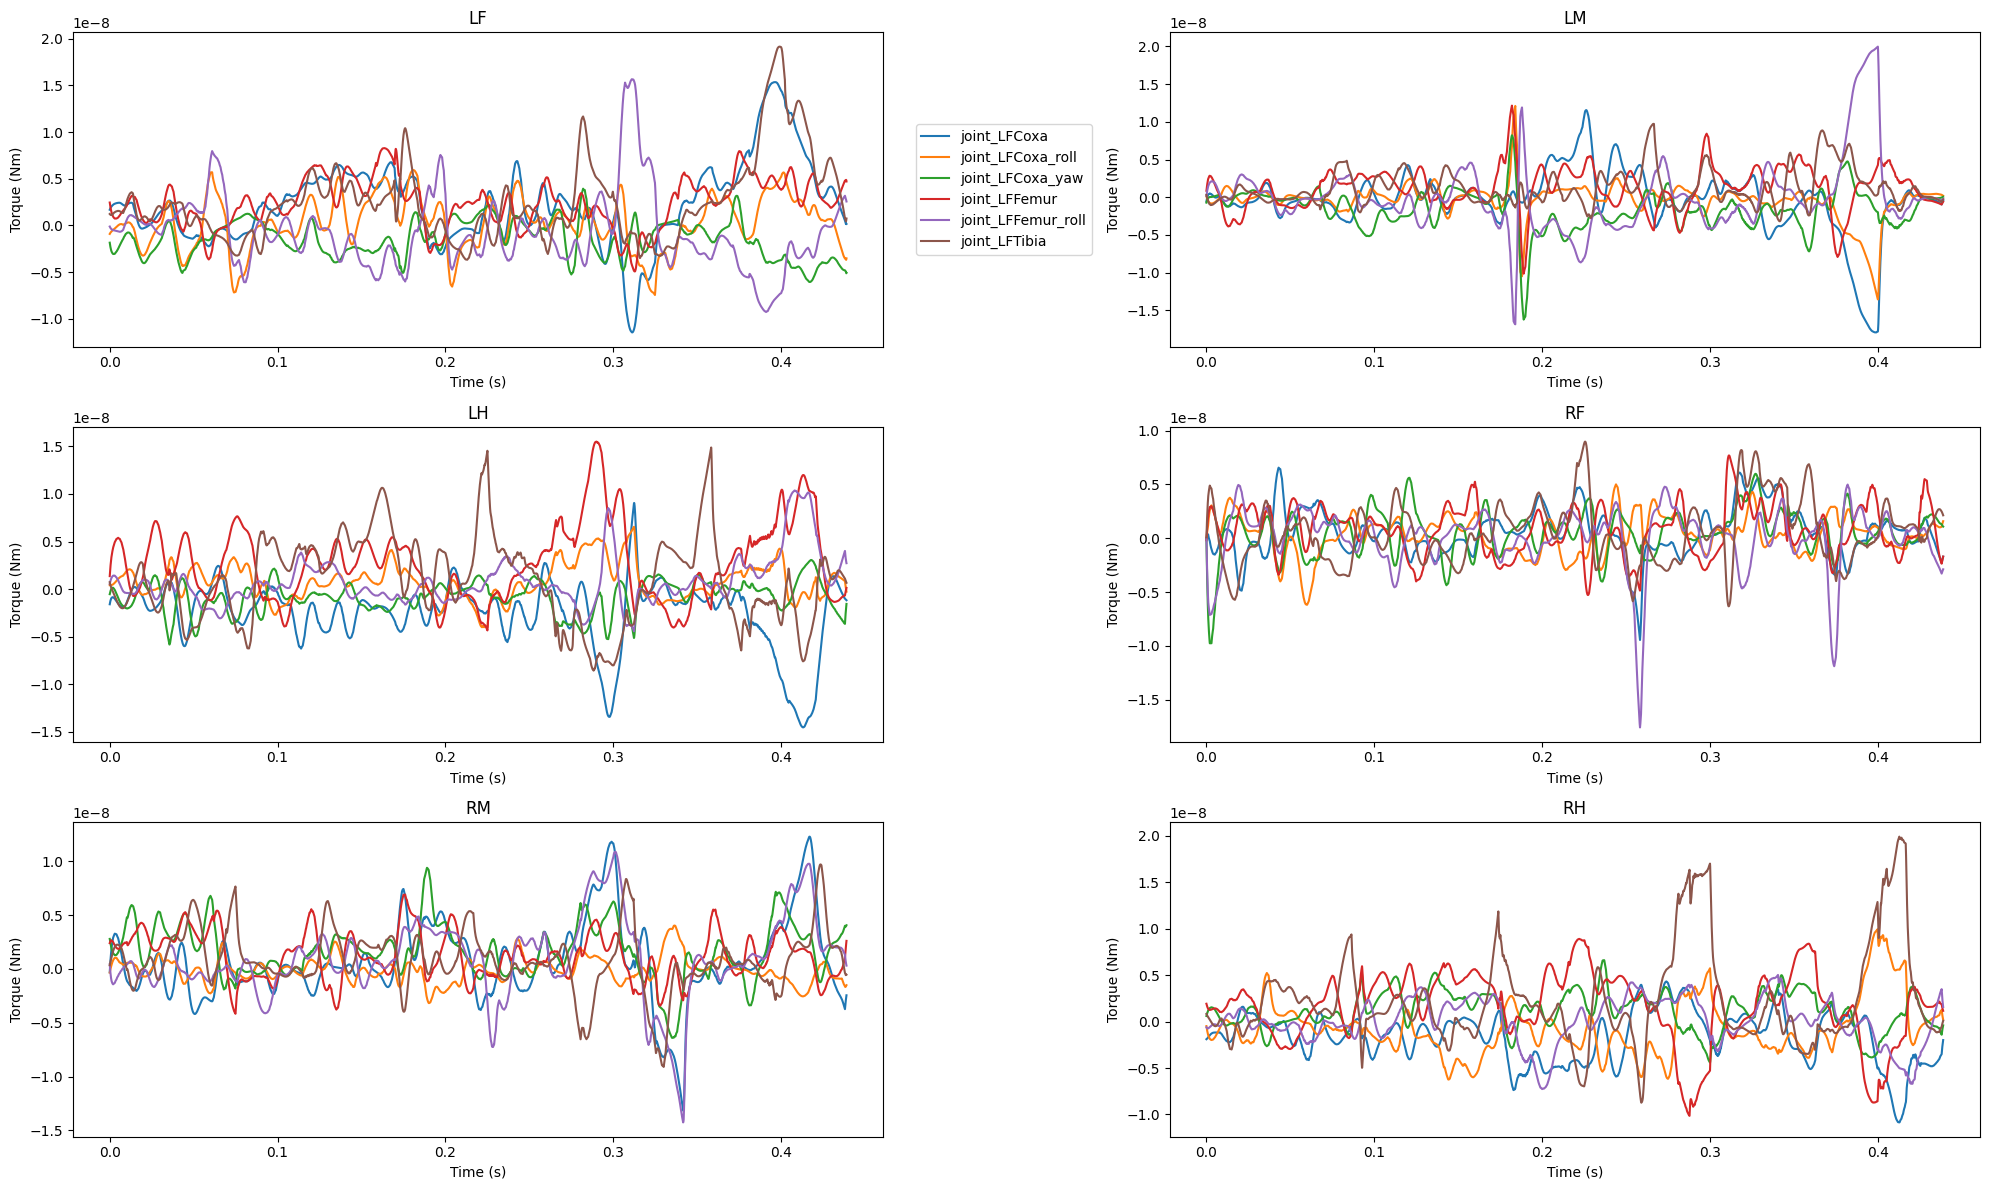

In [15]:
leg_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and not "Tarsus" in joint] for leg in legs}
leg_torques = np.array([[obs["joints"][2, leg_joints_to_id[leg]] for obs in obs_list] for leg in legs])
leg_joints = {leg: [joint for joint in monitored_joints if leg in joint and not "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(leg_joints[leg]):

        ax.plot(output_t, leg_torques[i, :, j], label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


### Torque in passive joints (Tarsal joints)

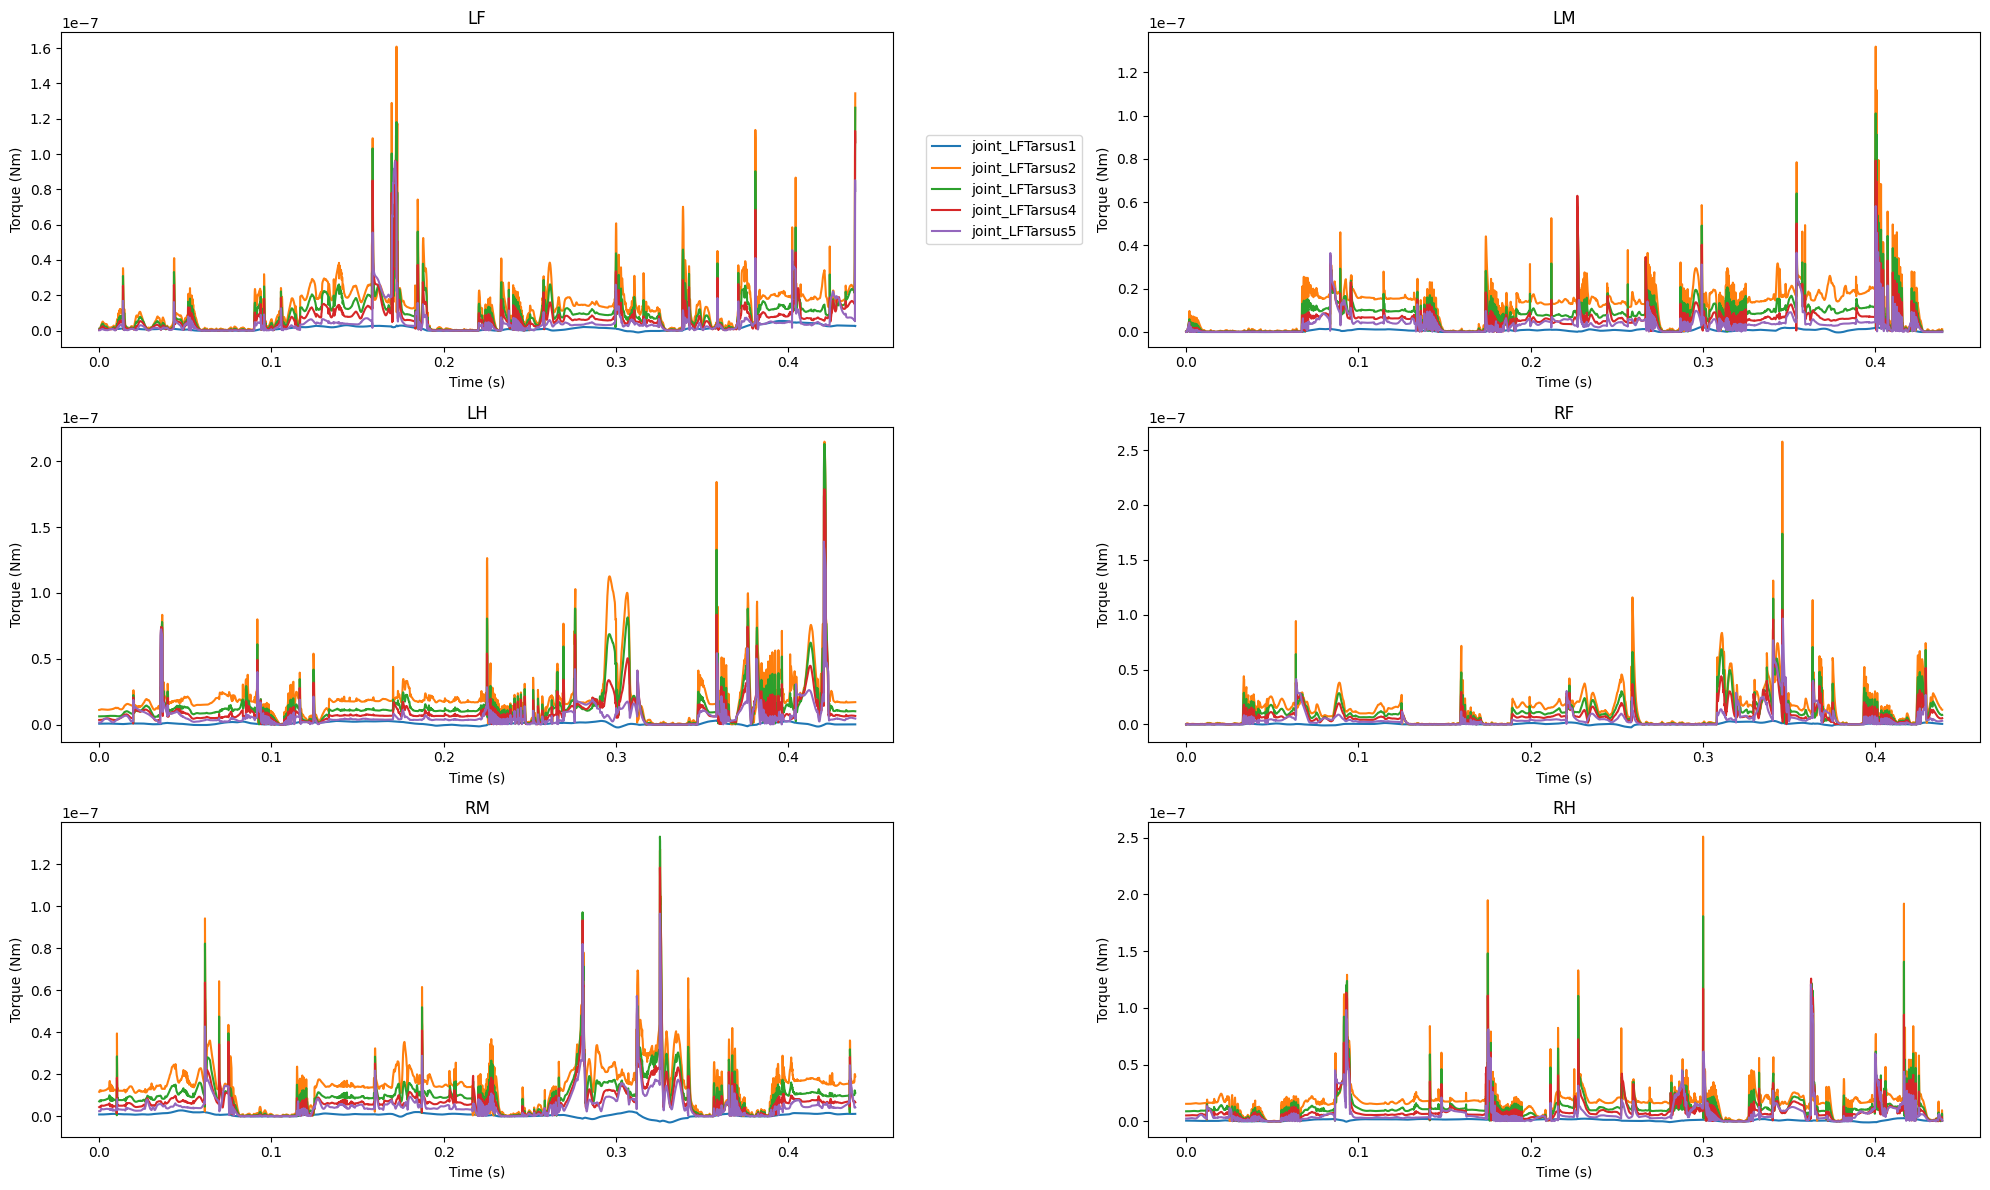

In [16]:
leg_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and "Tarsus" in joint] for leg in legs}
leg_torques = np.array([[obs["joints"][2, leg_joints_to_id[leg]] for obs in obs_list] for leg in legs])
leg_joints = {leg: [joint for joint in monitored_joints if leg in joint and "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(leg_joints[leg]):

        ax.plot(output_t, leg_torques[i, :, j], label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


## Floor contact force

While surely contributing to adaptative motor control ground reaction forces are really hard to measure in behaving *Drosophila* melanogaster. Using Neuromechfly it is possible to infer those forces and study their contribution to adaptative motor control.

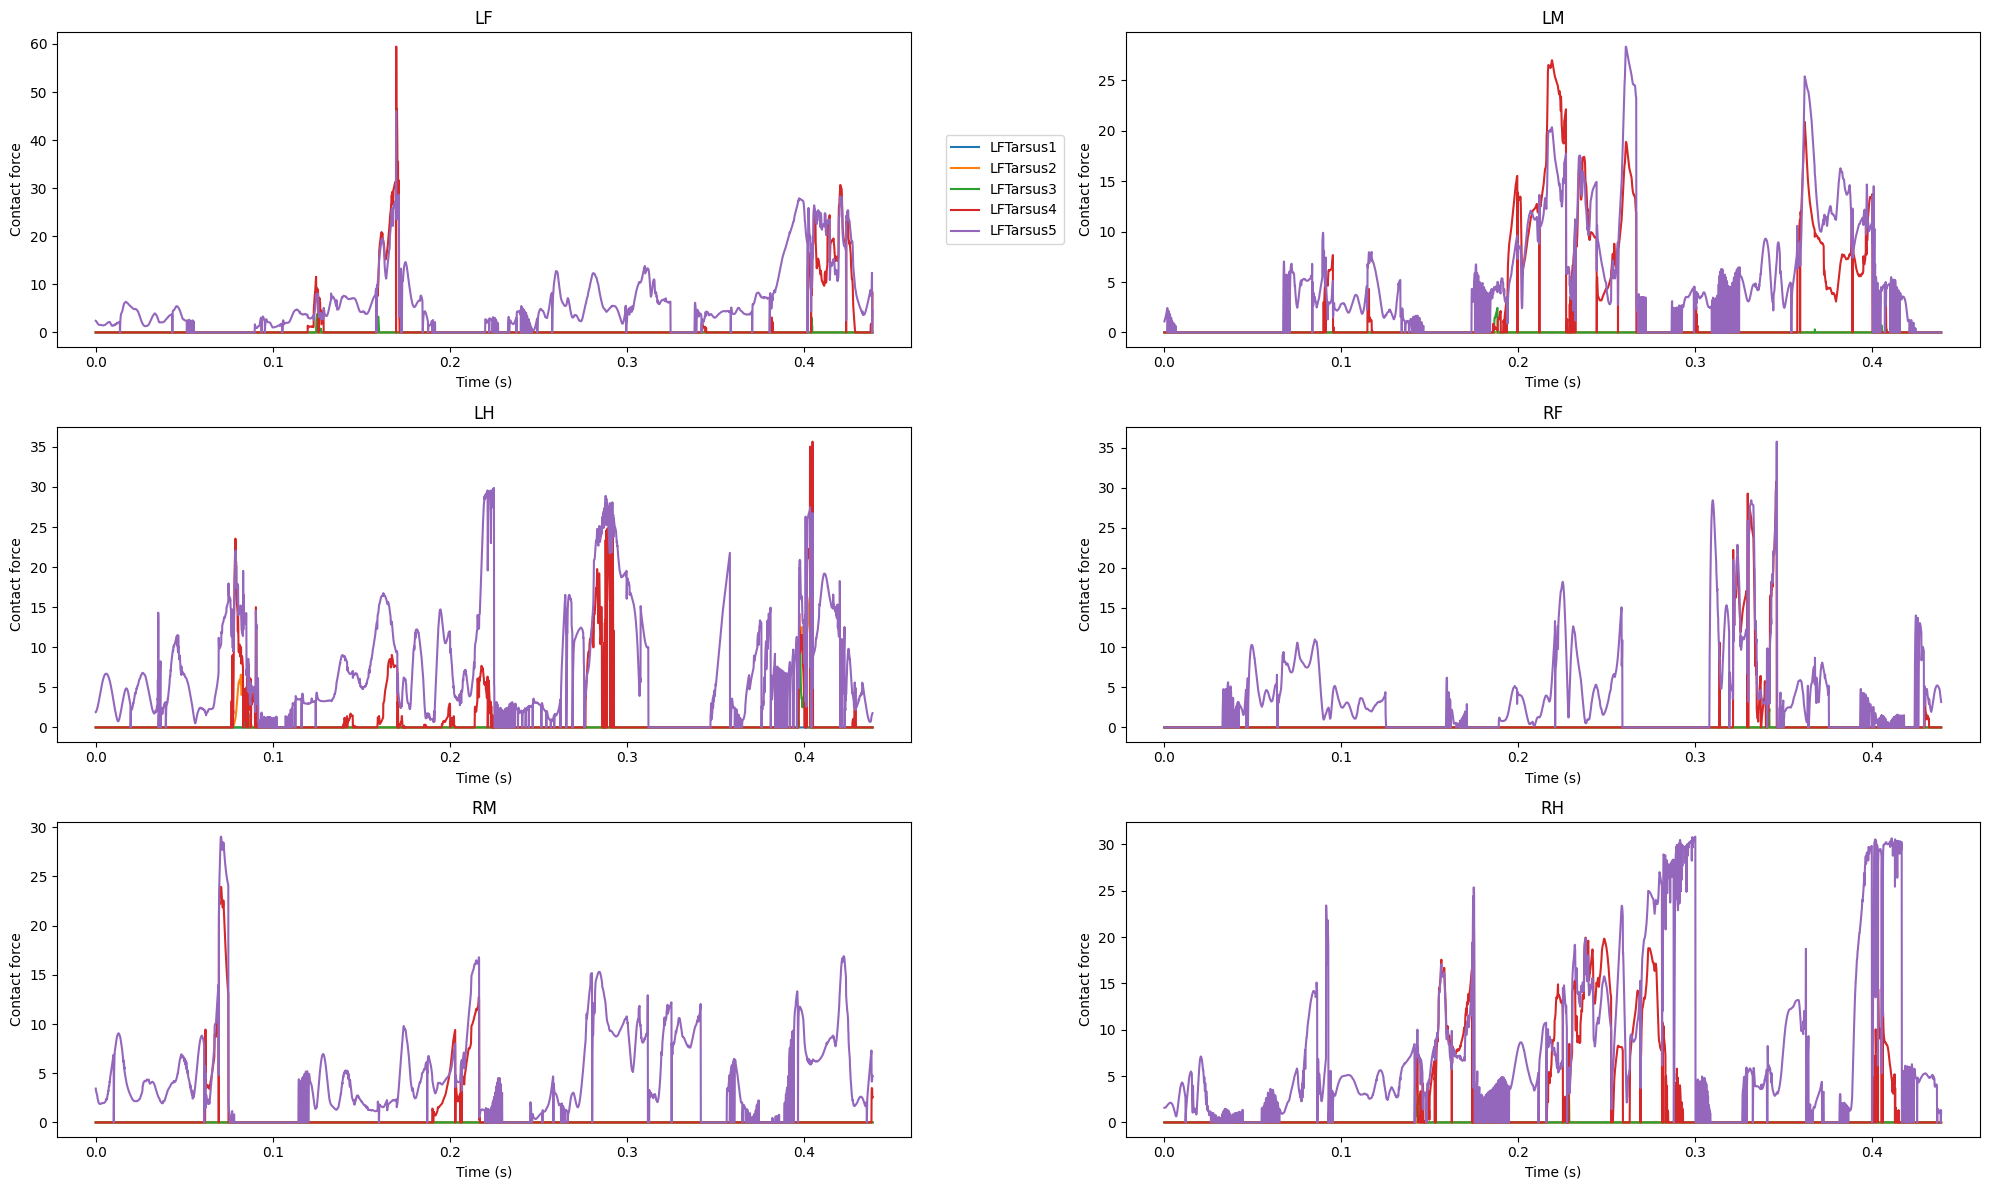

In [17]:
leg_tarsal_seg_contact_id = {leg: [i for i, tarsal_seg in enumerate(all_tarsi_links) if leg in tarsal_seg] for leg in legs}
leg_contacts = np.array([[np.linalg.norm(obs["contact_forces"][leg_tarsal_seg_contact_id[leg], :], axis=1) for obs in obs_list] for leg in legs])
leg_contact_tarsalseg = {leg: [tarsal_seg for tarsal_seg in all_tarsi_links if leg in tarsal_seg] for leg in legs}


time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, tarsalseg in enumerate(leg_contact_tarsalseg[leg]):
        ax.plot(output_t, leg_contacts[i, :, j], label=leg_contact_tarsalseg[leg][j])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Contact force")
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

    ax.set_title(leg)

## Tarsus angle

In our model, we do not enforce the position of the tarsal segments. Again due to the small size of the tarsal segments it is hard to measure their relative orientation. With Neuromechfly one can infer the angles between each tarsal segments and fill this gap. 

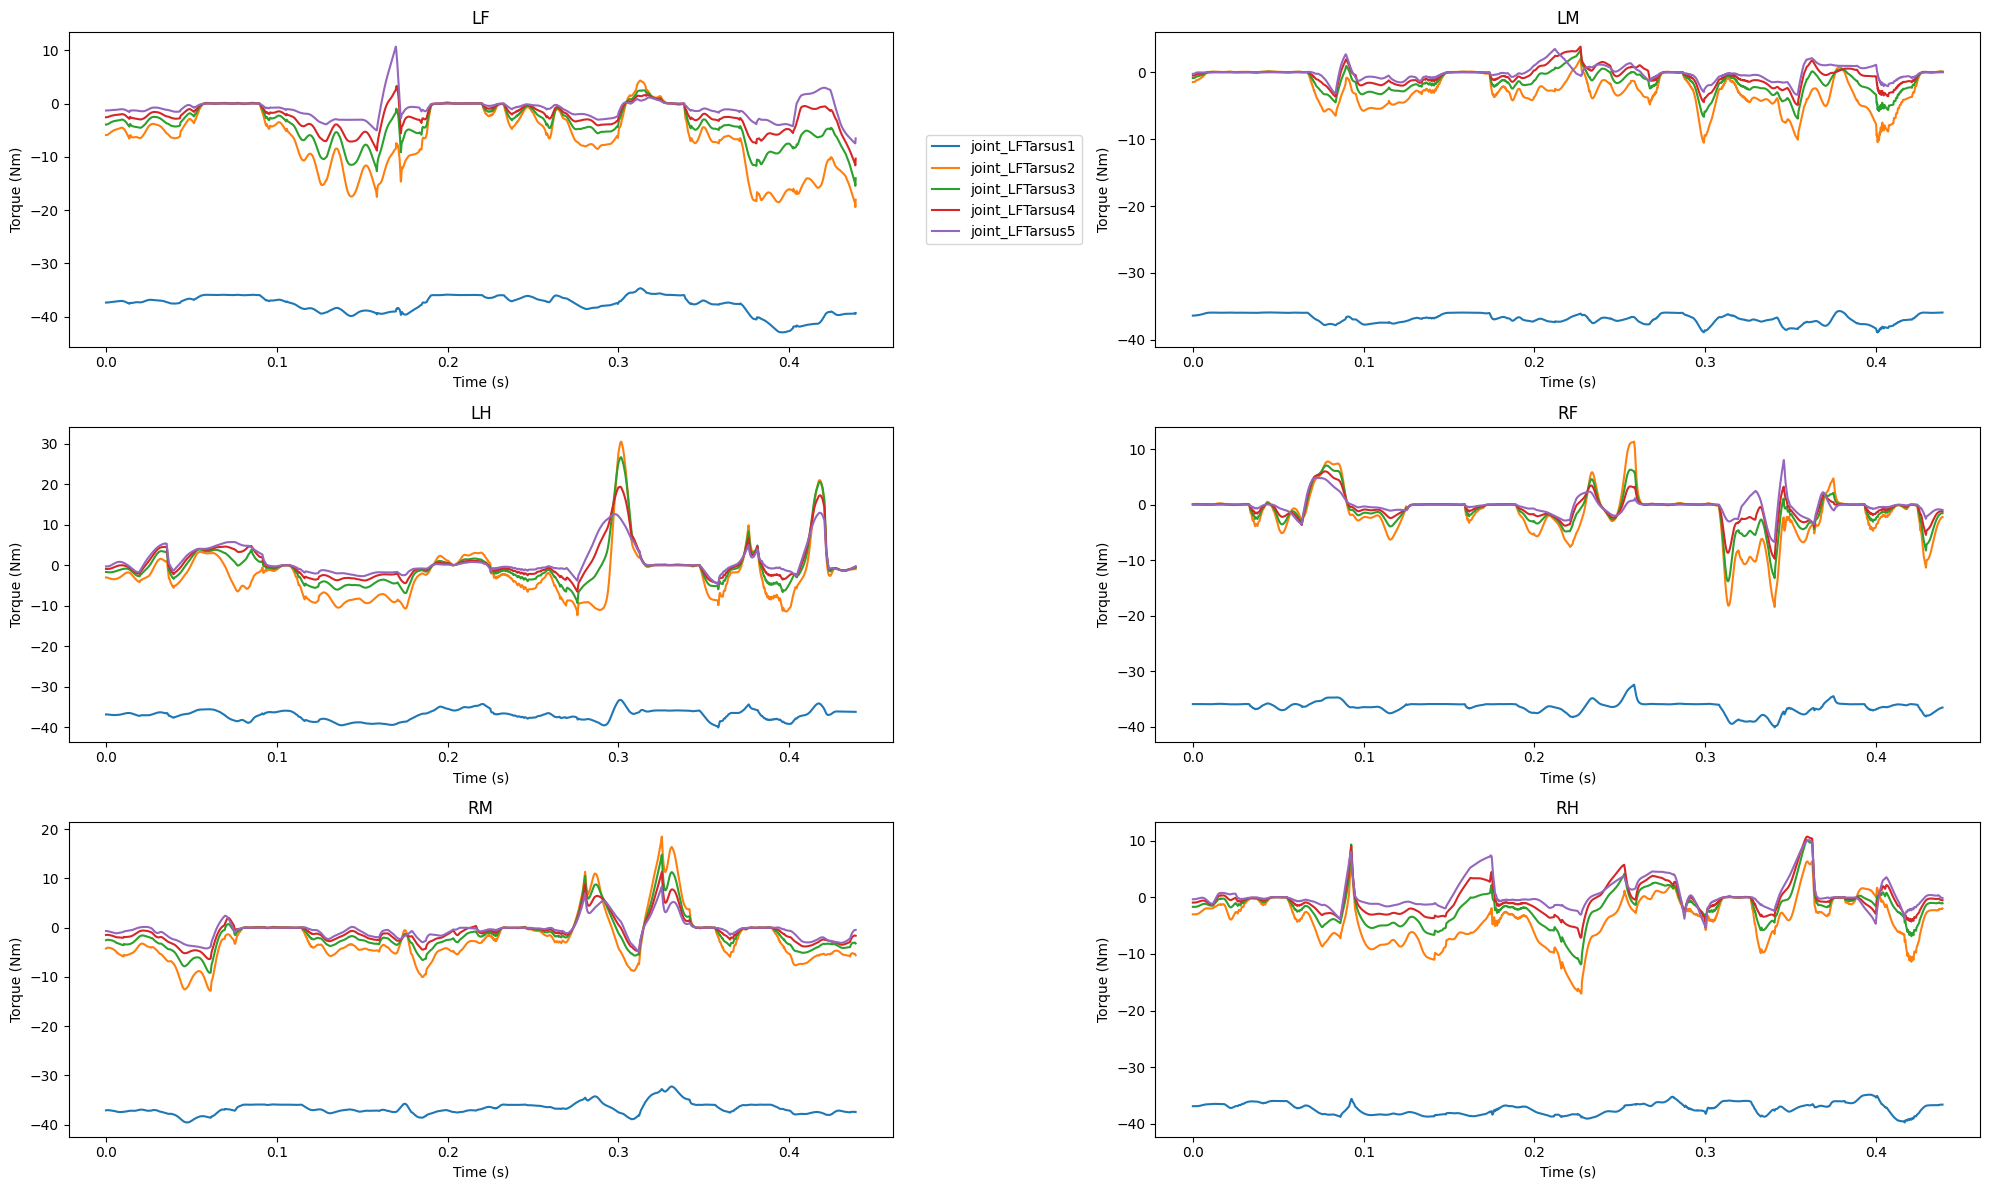

In [18]:
tarsus_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and "Tarsus" in joint] for leg in legs}
tarsus_jointangles = np.array([[obs["joints"][0, tarsus_joints_to_id[leg]] for obs in obs_list] for leg in legs])
tarsus_joints = {leg: [joint for joint in monitored_joints if leg in joint and "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(tarsus_joints[leg]):
        ax.plot(output_t, np.rad2deg(tarsus_jointangles[i, :, j]), label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


## Vision

Neurmechfly v2 is largely oriented toward the modelling of higher order sensory modalities. With Neuromechfly v2 it is now possible to emulate the vision experienced by the fruitfly during behavior. This is again almost impossible to obtain without relying on kinematic relay. 

In [19]:
if fly.enable_vision:
    from flygym.vision.visualize import visualize_visual_input
    visualize_visual_input(
        fly.retina,
        output_dir/ "retina_images.mp4",
        [obs["vision"] for obs in obs_list],
        raw_vision_list,
        fly.vision_update_mask[n_stabilization_steps:],
        playback_speed=play_speed,
    )
plt.close("all")

# play the video
Video(output_dir/ "retina_images.mp4")

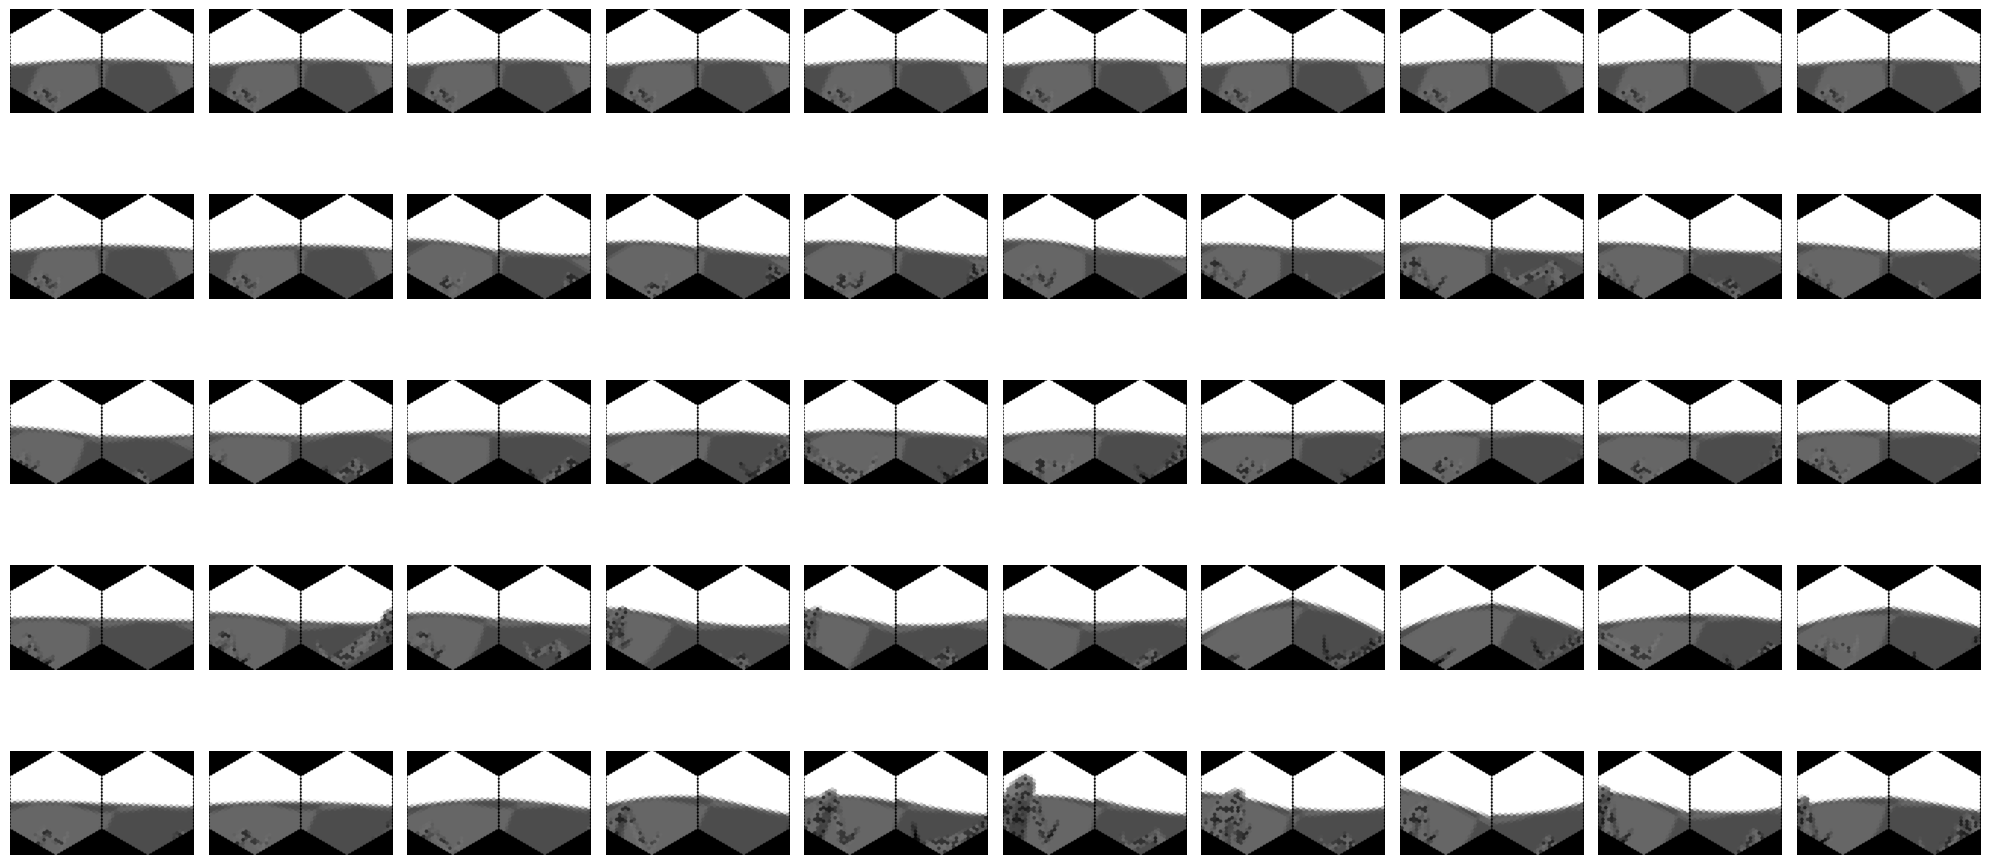

In [20]:
n_imgs = 50
n_cols = 10

fig, axs = plt.subplots(
    n_imgs // n_cols, n_cols, figsize=(20, 10), tight_layout=True
)

selected_ids = np.linspace(0, len(obs_list), n_imgs, endpoint=False, dtype=int)
flat_ax = axs.flatten()

for i, id in enumerate(selected_ids):
    
    # subdivide each ax in two
    eyes = [fly.retina.hex_pxls_to_human_readable(obs_list[id]["vision"][i]).max(axis=2) for i in range(2)]

    flat_ax[i].imshow(np.hstack(eyes), cmap="gray")
    flat_ax[i].axis("off")

plt.tight_layout()
plt.show()